# Notebook 04: Signal Construction and Position Sizing

In [37]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.tests import engle_granger
from src.signals import compute_zscore, generate_positions, position_to_trades

# Set plotting style
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

### 1. Load Data and Compute Spread

In [40]:
df = pd.read_csv("../data/processed/spy_ivv_daily.csv", index_col=0, parse_dates=True)

# Recompute cointegration (to get spread)
result = engle_granger(df["log_SPY"], df["log_IVV"])
spread = result['spread']
beta = result['beta']

print(f"Beta (hedge ratio): {beta:.4f}")
print(f"Spread mean: {spread.mean():.6f}")
print(f"Spread std: {spread.std():.6f}")

Beta (hedge ratio): 0.9987
Spread mean: -0.000000
Spread std: 0.001570


#### 2. Z-Score Transformation
# 
#### The spread itself is stationary, but its scale can vary. We normalize it to a z-score:
# 
#### $$z_t = \frac{s_t - \mu_t}{\sigma_t}$$
# 
#### where $\mu_t$ and $\sigma_t$ are computed over a rolling window (e.g., 60 days).
# 
#### Why z-score?
##### - Standardizes deviations (e.g., "2 std away" regardless of volatility regime)
##### - Makes threshold selection more intuitive
##### - Adapts to changing volatility

In [43]:
# Compute z-score
LOOKBACK = 60  # Rolling window for mean/std

zscore_df = compute_zscore(spread, lookback=LOOKBACK)
zscore_df.head()

,spread,spread_mean,spread_std,z
Date,,,,
2014-03-31,-0.002191,-0.002088,0.000270,-0.380898
2014-04-01,-0.002144,-0.002093,0.000268,-0.186737
2014-04-02,-0.002014,-0.002093,0.000268,0.297168
2014-04-03,-0.002392,-0.002099,0.000271,-1.077740
2014-04-04,-0.002374,-0.002100,0.000271,-1.011317


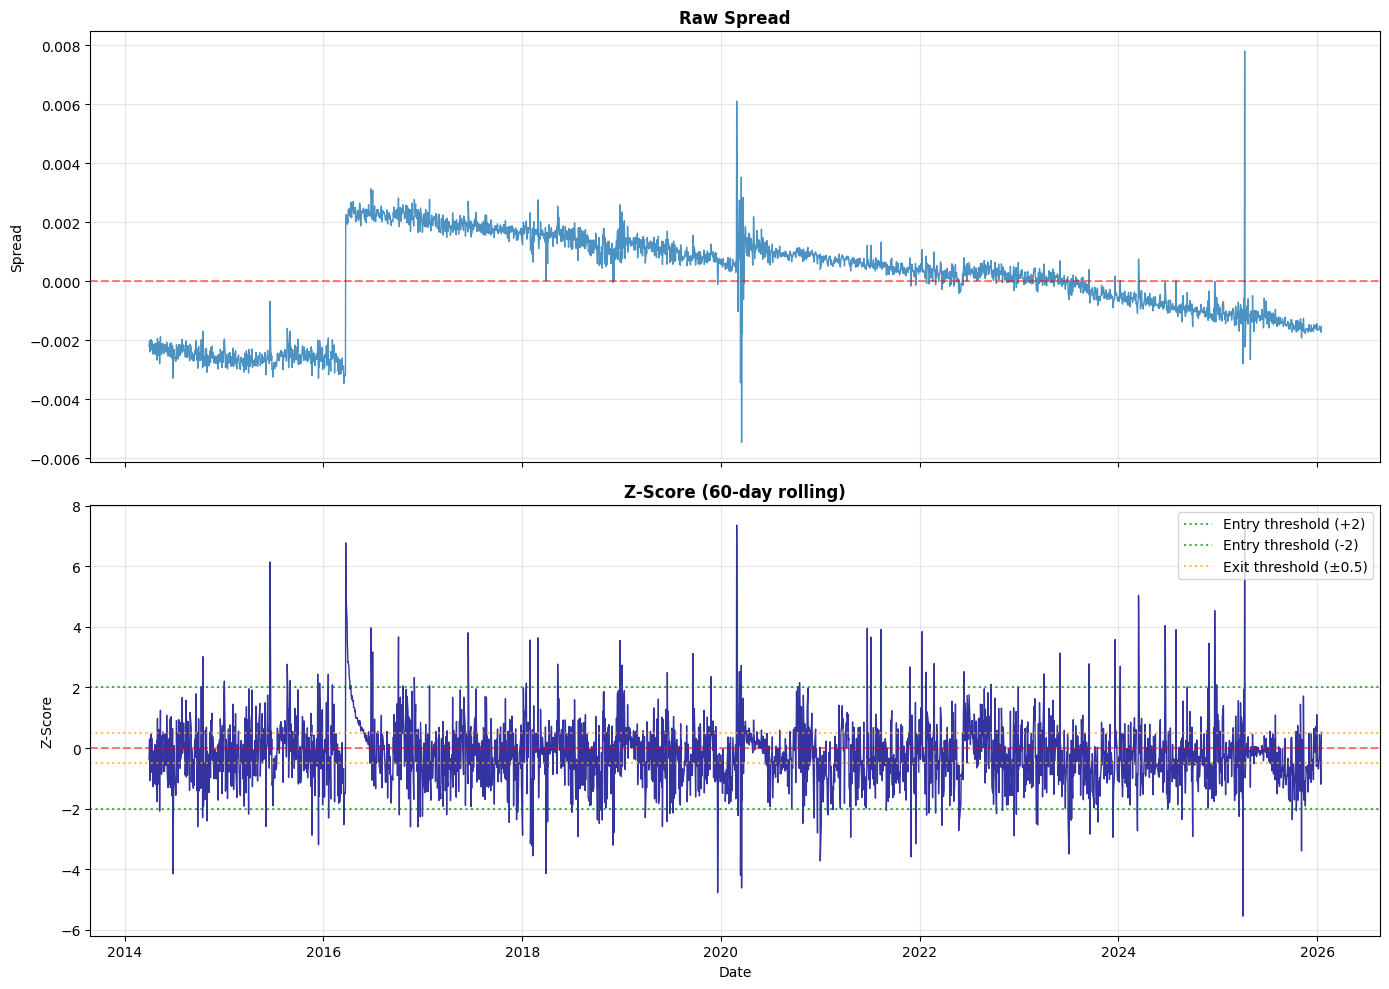

In [45]:
# Plot spread vs z-score
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Spread
axes[0].plot(zscore_df.index, zscore_df["spread"], linewidth=1, alpha=0.8)
axes[0].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[0].set_title("Raw Spread", fontsize=12, fontweight='bold')
axes[0].set_ylabel("Spread")
axes[0].grid(alpha=0.3)

# Z-score
axes[1].plot(zscore_df.index, zscore_df["z"], linewidth=1, alpha=0.8, color='darkblue')
axes[1].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[1].axhline(2, color='green', linestyle=':', alpha=0.7, label='Entry threshold (+2)')
axes[1].axhline(-2, color='green', linestyle=':', alpha=0.7, label='Entry threshold (-2)')
axes[1].axhline(0.5, color='orange', linestyle=':', alpha=0.7, label='Exit threshold (±0.5)')
axes[1].axhline(-0.5, color='orange', linestyle=':', alpha=0.7)
axes[1].set_title(f"Z-Score ({LOOKBACK}-day rolling)", fontsize=12, fontweight='bold')
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Z-Score")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("../reports/figures/04_spread_zscore.png", dpi=150)
plt.show()

#### 3. Trading Rules
# 
#### Entry Rules
##### - **Long spread** (buy SPY, sell β·IVV) when z < -2.0
##### - **Short spread** (sell SPY, buy β·IVV) when z > +2.0
# 
#### Exit Rules
##### - Close position when |z| < 0.5 (mean reversion)
# 
#### Risk Controls
##### - **Stop-loss:** Exit if |z| > 4.0 (divergence accelerating)
##### - **Max holding period:** Force exit after 20 days (avoid stale positions)
# 
#### Position Sizing
##### - Use β from cointegration regression as hedge ratio
##### - Example: If long spread with β=0.999:
##### - Long \$100 of SPY
##### - Short \$99.90 of IVV

In [48]:
# Generate positions
# ENTRY_THRESH = 2.0
# EXIT_THRESH = 0.5
# STOP_THRESH = 4.0
# MAX_HOLDING = 20

ENTRY_THRESH = 3.0  # Much wider - wait for big deviations
EXIT_THRESH = 0.0   # Exit at mean
STOP_THRESH = 6.0   # Wider stop
MAX_HOLDING = 30    # More patience




positions = generate_positions(
    zscore_df["z"],
    entry_threshold=ENTRY_THRESH,
    exit_threshold=EXIT_THRESH,
    stop_threshold=STOP_THRESH,
    max_holding_days=MAX_HOLDING
)

print(f"\nPosition statistics:")
print(f"  Long spread (+1): {(positions == 1).sum()} days ({(positions == 1).sum() / len(positions):.1%})")
print(f"  Short spread (-1): {(positions == -1).sum()} days ({(positions == -1).sum() / len(positions):.1%})")
print(f"  Flat (0): {(positions == 0).sum()} days ({(positions == 0).sum() / len(positions):.1%})")


Position statistics:
  Long spread (+1): 244 days (8.2%)
  Short spread (-1): 510 days (17.2%)
  Flat (0): 2215 days (74.6%)


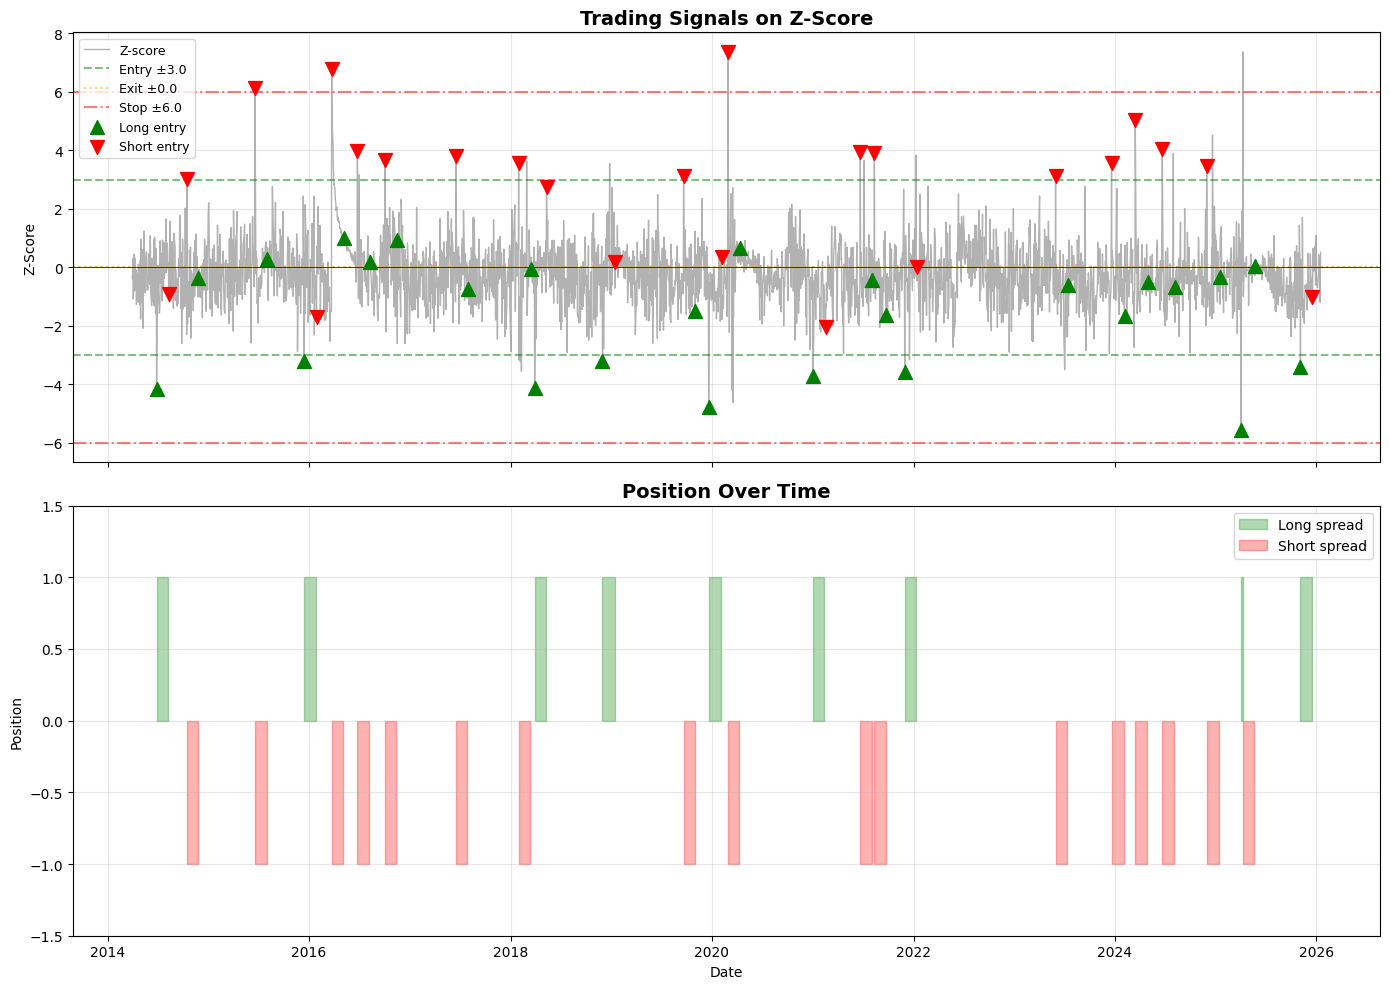

In [50]:
# Visualize signals
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Z-score with entry/exit markers
axes[0].plot(zscore_df.index, zscore_df["z"], linewidth=1, alpha=0.6, color='gray', label='Z-score')
axes[0].axhline(ENTRY_THRESH, color='green', linestyle='--', alpha=0.5, label=f'Entry ±{ENTRY_THRESH}')
axes[0].axhline(-ENTRY_THRESH, color='green', linestyle='--', alpha=0.5)
axes[0].axhline(EXIT_THRESH, color='orange', linestyle=':', alpha=0.5, label=f'Exit ±{EXIT_THRESH}')
axes[0].axhline(-EXIT_THRESH, color='orange', linestyle=':', alpha=0.5)
axes[0].axhline(STOP_THRESH, color='red', linestyle='-.', alpha=0.5, label=f'Stop ±{STOP_THRESH}')
axes[0].axhline(-STOP_THRESH, color='red', linestyle='-.', alpha=0.5)
axes[0].axhline(0, color='black', linewidth=0.5)

# Mark entry points
long_entries = (positions.diff() == 1)
short_entries = (positions.diff() == -1)
axes[0].scatter(zscore_df.index[long_entries], zscore_df["z"][long_entries], 
                color='green', marker='^', s=100, label='Long entry', zorder=5)
axes[0].scatter(zscore_df.index[short_entries], zscore_df["z"][short_entries], 
                color='red', marker='v', s=100, label='Short entry', zorder=5)

axes[0].set_title("Trading Signals on Z-Score", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Z-Score")
axes[0].legend(loc='upper left', fontsize=9)
axes[0].grid(alpha=0.3)

# Position over time
axes[1].fill_between(positions.index, 0, positions, 
                     where=(positions > 0), color='green', alpha=0.3, label='Long spread')
axes[1].fill_between(positions.index, 0, positions, 
                     where=(positions < 0), color='red', alpha=0.3, label='Short spread')
axes[1].set_title("Position Over Time", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Position")
axes[1].set_ylim(-1.5, 1.5)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("../reports/figures/04_trading_signals.png", dpi=150)
plt.show()


#### 4. Trade Log

In [53]:
trades = position_to_trades(positions)
print(f"\nTotal trades: {len(trades)}")
print(f"\nFirst 10 trades:")
print(trades.head(10))

if len(trades) > 0:
    print(f"\nTrade statistics:")
    print(f"  Average holding period: {trades['holding_days'].mean():.1f} days")
    print(f"  Max holding period: {trades['holding_days'].max()} days")
    print(f"  Min holding period: {trades['holding_days'].min()} days")
    print(f"  Long trades: {(trades['direction'] == 'long').sum()}")
    print(f"  Short trades: {(trades['direction'] == 'short').sum()}")


Total trades: 25

First 10 trades:
  entry_date  exit_date direction  holding_days
0 2014-06-27 2014-08-11      long            30
1 2014-10-15 2014-11-26     short            30
2 2015-06-19 2015-08-03     short            30
3 2015-12-14 2016-01-28      long            30
4 2016-03-23 2016-05-05     short            30
5 2016-06-24 2016-08-08     short            30
6 2016-10-03 2016-11-14     short            30
7 2017-06-16 2017-07-31     short            30
8 2018-01-30 2018-03-14     short            30
9 2018-03-29 2018-05-11      long            30

Trade statistics:
  Average holding period: 30.2 days
  Max holding period: 34 days
  Min holding period: 30 days
  Long trades: 9
  Short trades: 16


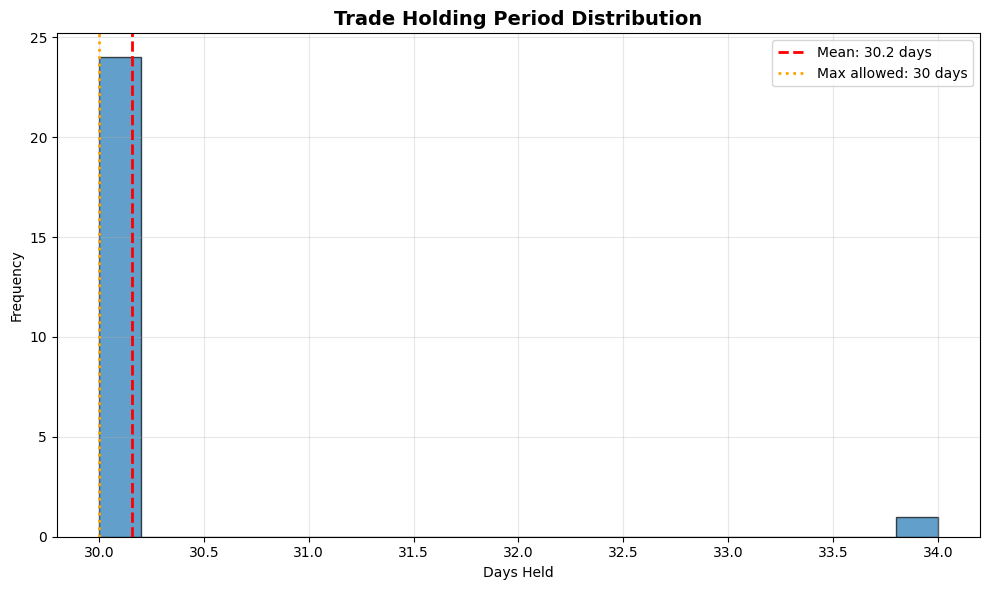

In [55]:
# Holding period distribution
if len(trades) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(trades['holding_days'], bins=20, edgecolor='black', alpha=0.7)
    ax.axvline(trades['holding_days'].mean(), color='red', linestyle='--', 
               linewidth=2, label=f"Mean: {trades['holding_days'].mean():.1f} days")
    ax.axvline(MAX_HOLDING, color='orange', linestyle=':', 
               linewidth=2, label=f"Max allowed: {MAX_HOLDING} days")
    ax.set_title("Trade Holding Period Distribution", fontsize=14, fontweight='bold')
    ax.set_xlabel("Days Held")
    ax.set_ylabel("Frequency")
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig("../reports/figures/04_holding_periods.png", dpi=150)
    plt.show()

#### 5. Save Signals for Backtest

In [58]:
# Combine everything into one dataframe
signal_df = df.copy()
signal_df['spread'] = spread
signal_df = signal_df.join(zscore_df[['spread_mean', 'spread_std', 'z']], how='left')
signal_df['position'] = positions

# Save
signal_df.to_csv("../data/processed/signals.csv")
trades.to_csv("../data/processed/trades.csv", index=False)

print("\nSaved signals to data/processed/signals.csv")
print("Saved trades to data/processed/trades.csv")


Saved signals to data/processed/signals.csv
Saved trades to data/processed/trades.csv


#### 6. Summary
# 
#### Signal Construction
##### - Z-score normalization makes thresholds interpretable
##### - Entry at ±2σ captures meaningful deviations
##### - Exit at ±0.5σ ensures we capture mean reversion
# 
#### Position Statistics
##### - Strategy is in a position ~{(positions != 0).sum() / len(positions):.1%} of the time
##### - Average holding: ~{trades['holding_days'].mean():.0f} days (aligned with half-life of 13 days)
##### - Trade frequency: {len(trades)} trades over {len(df)/252:.1f} years
# 
#### Next Step
##### - Backtest with transaction costs (Notebook 05)
##### - Evaluate out-of-sample performance